# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp cli/pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math

import zarr
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import colorcet

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

from decorrelation.pl import emi
from decorrelation.pc import pc2ras
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.dask import get_cuda_cluster

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_emi(coh:str, # coherence matrix
           ph:str, # output, wrapped phase
           emi_quality:str, #output, pixel quality
           ref:int=0, # reference image for phase
           point_chunk_size:int=None, # parallel processing point chunk size
           log:str=None, #log
           plot_emi_quality:bool=False, # if plot the emi quality
           vmin:int=1.0, # min value of emi quality to plot
           vmax:int=1.3, # max value of emi quality to plot
           ds_idx:str=None, # index of ds
           shape:tuple=None, # shape of one image
           emi_quality_fig:str=None, # path to save the emi quality plot, optional. Default, no saving
          ):
    coh_path = coh
    ph_path = ph
    emi_quality_path = emi_quality
    ds_idx_path = ds_idx

    logger = get_logger(logfile=log)
    coh_zarr = zarr.open(coh_path,mode='r')
    logger.zarr_info(coh_path,coh_zarr)

    if not point_chunk_size:
        point_chunk_size = coh_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size from coh dataset.')
    logger.info('parallel processing point chunk size: '+str(point_chunk_size))

    logger.info('starting dask CUDA local cluster.')
    cluster = LocalCUDACluster()
    client = Client(cluster)
    # for no reason, here when threads_per_worker is not 1, there will be some error.
    logger.info('dask local CUDA cluster started.')

    cpu_coh = da.from_zarr(coh_path, chunks=(point_chunk_size,*coh_zarr.shape[1:]))
    logger.darr_info('coh', cpu_coh)

    logger.info(f'phase linking with EMI.')
    coh = cpu_coh.map_blocks(cp.asarray)
    coh_delayed = coh.to_delayed()
    coh_delayed = np.squeeze(coh_delayed,axis=(-2,-1))

    ph_delayed = np.empty_like(coh_delayed,dtype=object)
    emi_quality_delayed = np.empty_like(coh_delayed,dtype=object)

    with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
        for block in it:
            idx = it.multi_index
            ph_delayed[idx], emi_quality_delayed[idx] = delayed(emi,pure=True,nout=2)(coh_delayed[idx])
            ph_delayed[idx] = da.from_delayed(ph_delayed[idx],shape=coh.blocks[idx].shape[0:2],meta=cp.array((),dtype=coh.dtype))
            emi_quality_delayed[idx] = da.from_delayed(emi_quality_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=cp.array((),dtype=cp.float32))

    ph = da.block(ph_delayed[...,None].tolist())
    emi_quality = da.block(emi_quality_delayed.tolist())

    cpu_ph = ph.map_blocks(cp.asnumpy)
    cpu_emi_quality = emi_quality.map_blocks(cp.asnumpy)
    logger.info(f'got ph and emi_quality.')
    logger.darr_info('ph', cpu_ph)
    logger.darr_info('emi_quality', cpu_emi_quality)

    logger.info('saving ph and emi_quality.')
    _cpu_ph = cpu_ph.to_zarr(ph_path,compute=False,overwrite=True)
    _cpu_emi_quality = cpu_emi_quality.to_zarr(emi_quality_path,compute=False,overwrite=True)
    
    if not plot_emi_quality:
        logger.info('computing graph setted. doing all the computing.')
        da.compute(_cpu_ph,_cpu_emi_quality)
        logger.info('computing finished.')
        cluster.close()
        logger.info('dask cluster closed.')
    else:
        logger.info('computing graph setted. doing all the computing.')
        emi_quality_result = da.compute(cpu_emi_quality,_cpu_ph,_cpu_emi_quality)[0]
        logger.info('computing finished.')
        cluster.close()
        logger.info('dask cluster closed.')

        logger.info('plotting emi_quality.')
        logger.info('reading is_ds bool array')
        ds_idx_result = zarr.open(ds_idx_path,mode='r')[:]

        emi_quality_raster = pc2ras(ds_idx_result,emi_quality_result,shape)
        logger.info('converting emi_quality from point cloud to raster.')
        fig, ax = plt.subplots(1,1)
        pcm = ax.imshow(emi_quality_raster,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set(title='EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
        fig.colorbar(pcm)
        if emi_quality_fig:
            logger.info('saving figure')
            fig.savefig(emi_quality_fig)
        logger.info('showing')
        fig.show()

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './ph/ds_can_ph.zarr'
ds_can_idx = './shp/ds_can_idx.zarr' # only for plot
ds_can_emi_quality = './pl/ds_can_emi_quality.zarr'
ref = 0
point_chunk_size = None
vmin=1.0
vmax=1.3
log = 'pl/de_emi.log'
emi_quality_fig = './pl/emi_quality.png'

In [ ]:
shape = zarr.open('./raw/rslc.zarr/','r').shape[:2]

2023-10-13 21:36:34 - de_emi - INFO - fetching args:
2023-10-13 21:36:34 - de_emi - INFO - coh = './co/ds_can_coh.zarr'
2023-10-13 21:36:34 - de_emi - INFO - ph = './ph/ds_can_ph.zarr'
2023-10-13 21:36:34 - de_emi - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2023-10-13 21:36:34 - de_emi - INFO - ref = 0
2023-10-13 21:36:34 - de_emi - INFO - point_chunk_size = None
2023-10-13 21:36:34 - de_emi - INFO - log = 'pl/de_emi.log'
2023-10-13 21:36:34 - de_emi - INFO - plot_emi_quality = True
2023-10-13 21:36:34 - de_emi - INFO - vmin = 1.0
2023-10-13 21:36:34 - de_emi - INFO - vmax = 1.3
2023-10-13 21:36:34 - de_emi - INFO - ds_idx = './shp/ds_can_idx.zarr'
2023-10-13 21:36:34 - de_emi - INFO - shape = (2500, 1834)
2023-10-13 21:36:34 - de_emi - INFO - emi_quality_fig = './pl/emi_quality.png'
2023-10-13 21:36:34 - de_emi - INFO - fetching args done.
2023-10-13 21:36:34 - de_emi - INFO - ./co/ds_can_coh.zarr zarray shape: (740397, 17, 17)
2023-10-13 21:36:34 - de_emi - INFO - ./co/ds_c

2023-10-13 21:36:36,515 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-13 21:36:36,515 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-13 21:36:36,524 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-13 21:36:36,524 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-13 21:36:36,528 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-13 21:36:36,528 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-13 21:36:36,532 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-13 21:36:36,532 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-10-13 21:36:36,533 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-10-13 21:36:36,534 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-

2023-10-13 21:36:42 - de_emi - INFO - dask local CUDA cluster started.
2023-10-13 21:36:42 - de_emi - INFO - coh dask array shape: (740397, 17, 17)
2023-10-13 21:36:42 - de_emi - INFO - coh dask array chunksize: (1000, 17, 17)
2023-10-13 21:36:42 - de_emi - INFO - coh dask array dtype: complex64
2023-10-13 21:36:42 - de_emi - INFO - phase linking with EMI.
2023-10-13 21:36:44 - de_emi - INFO - got ph and emi_quality.
2023-10-13 21:36:44 - de_emi - INFO - ph dask array shape: (740397, 17)
2023-10-13 21:36:44 - de_emi - INFO - ph dask array chunksize: (1000, 17)
2023-10-13 21:36:44 - de_emi - INFO - ph dask array dtype: complex64
2023-10-13 21:36:44 - de_emi - INFO - emi_quality dask array shape: (740397,)
2023-10-13 21:36:44 - de_emi - INFO - emi_quality dask array chunksize: (1000,)
2023-10-13 21:36:44 - de_emi - INFO - emi_quality dask array dtype: float32
2023-10-13 21:36:44 - de_emi - INFO - saving ph and emi_quality.
2023-10-13 21:36:44 - de_emi - INFO - computing graph setted. doi

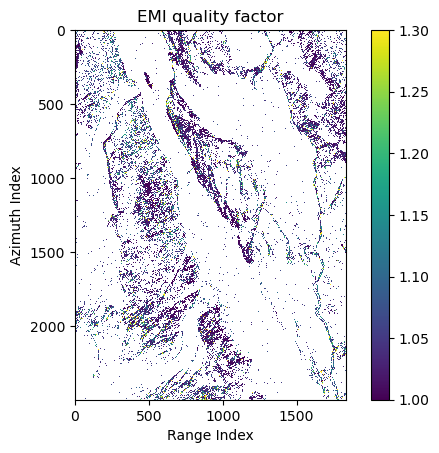

In [ ]:
de_emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref,point_chunk_size=point_chunk_size,log=log,plot_emi_quality=True,
       vmin=vmin,vmax=vmax,ds_idx=ds_can_idx,shape=shape,emi_quality_fig=emi_quality_fig)

In [ ]:
#| hide
#!de_emi ./ds_can_coh.zarr ./ds_can_ph.zarr ./ds_can_emi_quality.zarr --ref 0 --log de_emi.log --plot_emi_quality 1 --vmin 1.0 --vmax 1.3 --ds_idx ds_can_idx.zarr --shape (2500, 1834) --emi_quality_fig emi_quality.png

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()